### <u> Machine Learning</u>


Let's start with imports and reading the CSV file:

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix 
import numpy as np

In [5]:
df = pd.read_csv('combined_finished_df.csv')

In [6]:
df.head()

,Title,Author,Genre,# Of Pages,Description,Reviews Count,Rating
0,Wolverine and Jubilee: Curse of the Mutants,"Kathryn Immonen,Phil Noto",Sequential Art,120,"Straight out of the pages of ,X-Men, and right...",38,3
1,Don't You Want Me,India Knight,Womens Fiction,256,Sex. There's a lot of it about. But Stella isn...,44,3
2,The Story of Baha'u'llah: Promised One of All ...,Druzelle Cederquist,Religion,0,An inspiring and dramatically paced introducti...,8,5
3,The Bracelet,Roberta Gately,Fiction,318,Humanitarian aid Abby Howell and reporter Nick...,80,3
4,Cresting Tide,Brenda Cothern,Romance,0,"Alternate Cover B00895DXSY ,Peter, fleeing fro...",29,3


------------
Declaring variables to use with train_test method

In [8]:
y = df['Rating']
text = df['Description']
X = df.drop(columns = ['Rating'])

Let's divide the data to 2 different sections, Categorical ones and Numericals:

In [9]:
# Extracting only the categoricals features 
categoricals = list(X.select_dtypes('object').columns)
categoricals.remove('Description')

# Defining a list containing numerical columns only
numericals = list(X.select_dtypes(exclude=['object']).columns)
if 'Unnamed: 0' in numericals: # Using Pandas always adds a redundant column, so it should be removed.
    numericals.remove('Unnamed: 0')

---------

After some research on the internet, I came across another algorithm other than CountVectorizer.

(Sources: https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

"The TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents."

To use the description feature we will have to use an algorithm to turn the paragraphs into vectors that the model can use.
We will use two different algorithms that I found after reading online; CountVectorizer and TfidfVectorizer.
First we will use CountVectorizer and invoke different types of algorithms on the data after pre-processing.

# CountVectorizer

In [37]:
# Limiting the process to recognize only words that are shown more than 50 times
# max_features parameter meaning is limiting the vocabulary size to an upper bound of the specified number
vectorizer = CountVectorizer(stop_words='english',max_features=20000)
v = vectorizer.fit_transform(text)

# Creating a DataFrame containing the embedding: vector representation of text features.
#v = tfidf.fit_transform(text)
embedding = pd.DataFrame(v.toarray().astype(np.uint8), columns = vectorizer.get_feature_names())

-----------
Sources:
https://www.mygreatlearning.com/blog/label-encoding-in-python/

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In the following block of code, I'll use LabelEncoder, which helps encoding the features into numbers.

In [38]:
# Initializing LabelEncoder, training the features and adding it to a list

features = []
for feature in categoricals:
    # Encoding each categorical feature. The reason to do this iterativly
    # and not for all the categoricals features once is because accessing it non-iterativly
    # way messes up the labels
    encoder = LabelEncoder()
    encoder = encoder.fit(X[feature])
    encoded = encoder.transform(X[feature])
    encoded = np.array(encoded)
    features.append(encoded)

# Features holds the encoded categorical variables
features = np.array(features)
features = np.transpose(features) # Had a problem here with array dimensions, that was the solution

features = pd.DataFrame(features,columns=categoricals)

# num_features holds all numerical features for scaling
num_features = pd.concat([X[numericals], features], axis=1)

# Initializing the scaler
scaler = StandardScaler()
scaler = scaler.fit(num_features)

features = scaler.transform(num_features)
features = pd.DataFrame(features,columns = numericals + categoricals)

In [39]:
# Combining the encoded dataframe (which holds both the numerical
# and categorical features) with the embedding of the description feature.
final_df = pd.concat([features, embedding], axis=1)

In [46]:
# There was a problem with max_iter parameter, link to solution from StackOverflow:
# https://stackoverflow.com/a/62659927/15633316
pipeline = Pipeline(steps=[('model', LogisticRegression(random_state=42, max_iter=400))])

# Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
grid = {'model__C' : [0.00001, 0.5, 1]}

grid_search = GridSearchCV(estimator = pipeline,
                           param_grid = grid,
                           cv = 5,
                           return_train_score=True)
grid_search.fit(final_df, y)

E:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
E:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        LogisticRegression(max_iter=400,
                                                           random_state=42))]),
             param_grid={'model__C': [1e-05, 0.5, 1]}, return_train_score=True)

In [47]:
print(f"Average train score: {grid_search.cv_results_['mean_train_score'].mean()}")
print(f"Average Test score: {grid_search.cv_results_['mean_test_score'].mean()}")

Average train score: 0.829240848823113
Average Test score: 0.5302515999678653


In [42]:
# This block of code was ran with C values of : 0.1,0.01,0.001
print(f"Average train score: {grid_search.cv_results_['mean_train_score'].mean()}")
print(f"Average Test score: {grid_search.cv_results_['mean_test_score'].mean()}")

Average train score: 0.7833381157843279
Average Test score: 0.5715111678766579


In [43]:
# C = grid_search.best_params_
pipeline = Pipeline(steps=[('model', LogisticRegression(random_state=42, max_iter=400))])

# NOTE: For GridSearch I didn't need to split the dataset because 
# it does cross-validation for us, hence for gathering more information
# from confusion matrix we train a model for visualization purposes.
X_train, X_test, y_train, y_test = train_test_split(final_df, y)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('model', LogisticRegression(max_iter=400, random_state=42))])

0.5496840896036761

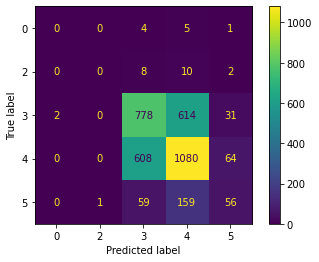

In [45]:
plot_confusion_matrix(pipeline['model'], X_test, y_test)

------------

Now let's run the same process, this time using Random Forest

In [14]:
pipeline1 = Pipeline(steps=[('model',RandomForestClassifier(random_state=42))])
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

grid = {'model__max_depth': [10,50,100,None]}
grid_search = GridSearchCV(estimator = pipeline1,
                           param_grid = grid,
                           cv = 5,
                           return_train_score=True)
grid_search.fit(final_df, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'model__max_depth': [10, 50, 100, None]},
             return_train_score=True)

In [15]:
print(f"Average train score: {grid_search.cv_results_['mean_train_score'].mean()}")
print(f"Average Test score: {grid_search.cv_results_['mean_test_score'].mean()}")

Average train score: 0.895239659121279
Average Test score: 0.5474141581163292


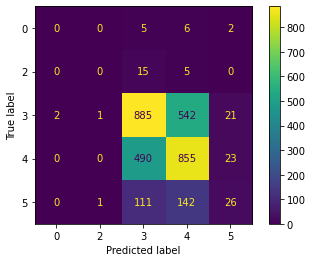

In [16]:
estimator = grid_search.best_estimator_['model']
X_train, X_test, y_train, y_test = train_test_split(final_df,y)

pipeline1.fit(X_train, y_train)

plot_confusion_matrix(pipeline1, X_test, y_test)

# TfidfVectorizer

In [51]:
# Limiting the process to recognize only words that are shown more than 50 times
# max_features parameter meaning is limiting the vocabulary size to an upper bound of the specified number
tfidf = TfidfVectorizer(min_df=50, max_features = 80000)
v = vectorizer.fit_transform(text)

# Creating a DataFrame containing the embedding: vector representation of text features.
embedding1 = pd.DataFrame(v.toarray().astype(np.uint8), columns = vectorizer.get_feature_names())

In [52]:
# Combining the encoded dataframe (which holds both the numerical
# and categorical features) with the embedding of the description feature.
final_df = pd.concat([features, embedding1], axis=1)

In [54]:
pipeline = Pipeline(steps=[('model', LogisticRegression(random_state=42, max_iter=400))])

# Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
grid = {'model__C' : [0.1,0.01,0.001]}

grid_search = GridSearchCV(estimator = pipeline,
                           param_grid = grid,
                           cv = 5,
                           return_train_score=True)
grid_search.fit(final_df, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        LogisticRegression(max_iter=400,
                                                           random_state=42))]),
             param_grid={'model__C': [0.1, 0.01, 0.001]},
             return_train_score=True)

In [55]:
print(f"Average train score: {grid_search.cv_results_['mean_train_score'].mean()}")
print(f"Average Test score: {grid_search.cv_results_['mean_test_score'].mean()}")

Average train score: 0.783338115784328
Average Test score: 0.5715111678766579


E:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


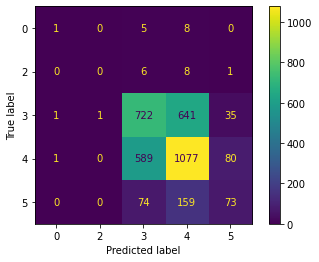

In [57]:
estimator = grid_search.best_estimator_['model']
X_train, X_test, y_train, y_test = train_test_split(final_df,y)

pipeline.fit(X_train, y_train)

plot_confusion_matrix(pipeline, X_test, y_test)

NOTE: During the ML phase I tried to handle the overfitting problem using various ways. Here's the source for the solutions used in this notebook:
https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e

End of ML phase.